===========================
 # ADLBHY Analysis       
===========================
### This code produces the following **figures**
- eDISH plot
- Abormal Patient inspection


## Load __packages__ 

In [121]:
library(tidyverse)
library(haven)
library(Cairo)

## Set working **directory**

In [122]:
setwd("/mnt/imported/data/ADAM")

## Read in **ADLBHY**

In [123]:
adlbhy <- read_sas("adlbhy.sas7bdat")

---
## eDISH Plot
=============
### Make the **ALT** data
##### Taking the max **AVAL** by USUBJID for max **ALT**

In [124]:
adlbhy_alt <- adlbhy %>%
  filter(ANL01FL == "Y" & PARAMCD == "ALT")  %>%
  group_by(USUBJID) %>%
  mutate(max_aval = max(AVAL),
         max_ALT_ULN = max(R2A1HI)) %>%
  ungroup()

### Make the **BILI** data
##### Taking the max **AVAL** by USUBJID for max **BILI**

In [125]:
adlbhy_bili_pre <- adlbhy %>%
  filter(ANL01FL == "Y" & PARAMCD == "BILI")  %>%
  group_by(USUBJID) %>%
  mutate(max_aval = max(AVAL),
         max_BILI_ULN = max(R2A1HI)) %>%
  ungroup()

#### Keep only necessary variables

In [126]:
adlbhy_bili <- adlbhy_bili_pre[,c("USUBJID", "AVISITN", "max_BILI_ULN")]

### Merge all together

In [127]:
edish_data_prep <- merge(adlbhy_alt, adlbhy_bili, by = c("USUBJID", "AVISITN"), all = TRUE)

## Make the **eDISH plot**
#### Find the unique data for each subject

In [128]:
edish_data_unique <- unique(edish_data_prep[,c("USUBJID",  "max_ALT_ULN",  "max_BILI_ULN")])

### Find the number of **patients** that fall within each *bound*

 1. "Normal" - 1 $>$ **max(ALT)** AND  1 $>$ **max(BILI)**
 2. "" - Normal but (1 $\le$ **max(ALT)** $<$ 3) OR (1 $\le$ **max(BILI)** $<$ 2)
 3. "Hy's Law"
 4. "Hyperbilirubinemia"
 5. "Temple's Corollary"

In [129]:
edish_summary_prep <- edish_data_unique %>%
  mutate(status = ifelse(max_ALT_ULN < 1 & max_BILI_ULN < 1, "Normal",
                         ifelse(max_ALT_ULN < 3 & max_BILI_ULN < 2 & max_ALT_ULN >= 1 , "",
                                ifelse(max_ALT_ULN < 3 & max_BILI_ULN < 2 & max_BILI_ULN >= 1, "",
                                       ifelse(max_ALT_ULN >= 3 & max_BILI_ULN >= 2, "Hy's Law",
                                              ifelse(max_ALT_ULN < 3 & max_BILI_ULN >= 2, "Hyperbilirubinemia",
                                                     ifelse(max_ALT_ULN >= 3 & max_BILI_ULN < 2, "Temple's Corollary",
                                                            NA))))))) %>%
  group_by(status) %>%
  summarise(USUBJID, 
            max_ALT_ULN,
            max_BILI_ULN,
            n = n()) %>%
  ungroup()

`summarise()` has grouped output by 'status'. You can override using the
`.groups` argument.


In [130]:
# If any counts = 0, that status will not appear.  Merge this on to make 0 appear
status_all <- data.frame(status = c("Normal", "", "Hy's Law", "Hyperbilirubinemia", "Temple's Corollary"),
                         n_0 = rep(0,5))

edish_summary_pre <- merge(edish_summary_prep, status_all, by = "status", all = TRUE) 

edish_summary <- edish_summary_pre %>%
  summarise(USUBJID,
            status,
            n = ifelse(is.na(n) == TRUE, 0, n),
            x_lab = ifelse(status == "Normal", floor(min(max_ALT_ULN)), 
                           ifelse(status == "", 1,
                                  ifelse(status == "Hy's Law", 3,
                                         ifelse(status == "Hyperbilirubinemia",  floor(min(max_ALT_ULN)),
                                                ifelse(status == "Temple's Corollary", 3, NA))))),
            y_lab = ifelse(status == "Normal", floor(min(max_BILI_ULN)), 
                           ifelse(status == "", floor(min(max_BILI_ULN)),
                                  ifelse(status == "Hy's Law", 2,
                                         ifelse(status == "Hyperbilirubinemia", 2,
                                                ifelse(status == "Temple's Corollary", floor(min(max_BILI_ULN)),
                                                       NA))))))

#### Get just the unique counts for status to be used as text on plot

In [131]:
status_count <- unique(edish_summary[,c("status", "n", "x_lab", "y_lab")])


#### Merge onto *edish_data_prep* to make *edish_data*

In [132]:
edish_data <- merge(edish_data_prep, edish_summary, by = "USUBJID", all = TRUE)

## The **eDISH plot**

#### Save output as a PDF

In [133]:
setwd("/mnt/artifacts/results")

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


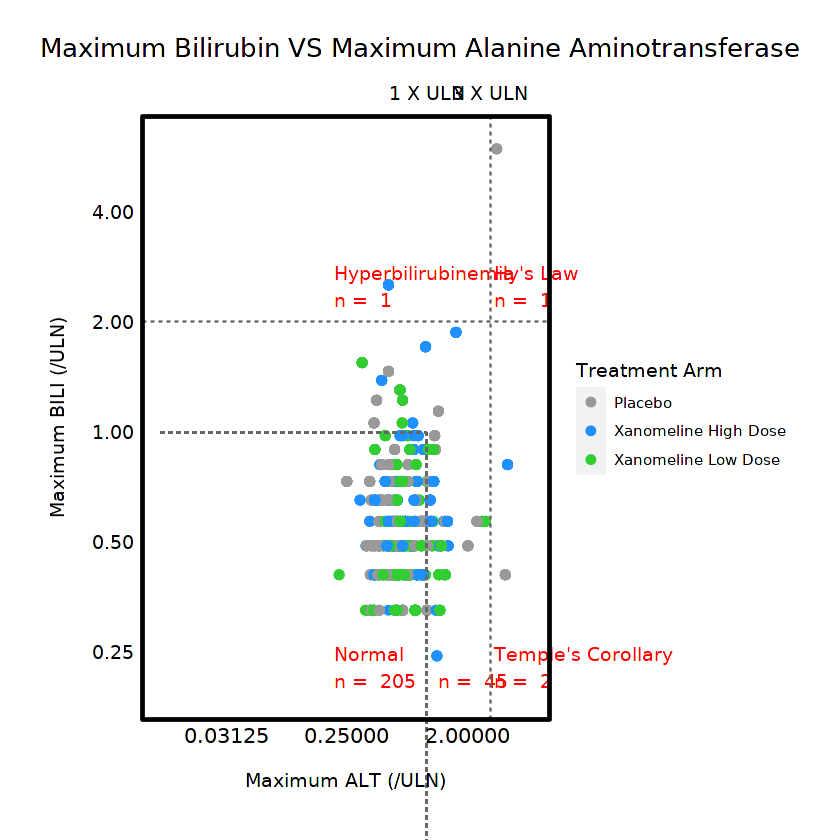

In [139]:
# pdf(file = "f_edish_jupyter.pdf", height = 8, width = 14)

ggplot(data = edish_data) +
  
  # add labels of number in each status
  geom_text(data = status_count,
            aes(x = x_lab + 0.2,
                y = y_lab + 0.2),
            label = paste(status_count$status, "\nn = ", status_count$n),
            hjust = -0,
            vjust = -0,
            col = "red") +
  
  # scatter points
  geom_point(aes(x = max_ALT_ULN,
                 y = max_BILI_ULN,
                 color = TRTA),
             size = 2) +
  
  # set point colours
  scale_color_manual(values = c("grey60", "dodgerblue", "limegreen"),
                     name = "Treatment Arm") +
  
  # line of lower limit (requires two lines)
  geom_segment(aes(x = 1,
                   xend = 1,
                   y = 0.01,
                   yend = 1),
               linetype = "dashed",
               col = "grey40") +
  geom_segment(aes(x = 0.01,
                   xend = 1,
                   y = 1,
                   yend = 1),
               linetype = "dashed",
               col = "grey40") +
  
  # line of upper limit 
  geom_hline(aes(yintercept = 2),
             linetype = "dashed",
             col = "grey40") +
  geom_vline(aes(xintercept = 3),
             linetype = "dashed",
             col = "grey40") +
  
  # annotate outside of plot where 1 X ULN and 3 X ULN for ALT
  annotate("text",
           x = c(1,3),
           y = c(max(max(edish_data$max_BILI_ULN),4) + 2.5,
                 max(max(edish_data$max_BILI_ULN), 4) + 2.5),
           label = c("1 X ULN", "3 X ULN")
  ) +
  
  # set axis limits 
  coord_cartesian(ylim = c(min(edish_data$max_BILI_ULN) - 0.05,
                           max(edish_data$max_BILI_ULN) + 0.2),
                  clip = "off") +
  
  # axis labels 
  labs(x = "Maximum ALT (/ULN)",
       y = "Maximum BILI (/ULN)",
       title = "Maximum Bilirubin VS Maximum Alanine Aminotransferase") +
  
  # set log scales for x an y axis, 
  scale_x_continuous(trans='log2') +
  scale_y_continuous(trans='log2') +
  expand_limits(x=c(0, 6), y= c(0, 4)) + # the smallest axis limits given, but will be bigger if data points are
  
  # theme
  theme( strip.background = element_blank(),
         # legend.position = "none",
         axis.line = element_line(colour = "black"),
         axis.ticks = element_blank(),
         strip.text = element_text(size = 8,
                                   margin = margin(b = 5)),
         panel.background = element_rect(fill = "white"),
         panel.border = element_rect(colour = "black", fill=NA, size=1),
         #panel.grid = element_line(colour = "black"),
         plot.title = element_text(size = 15,
                                   hjust = 0.5,
                                   vjust = 10),
         plot.margin = margin(50, 30, 30, 30),
         plot.title.position = 'plot',
         panel.spacing = unit(0.2, 'in'),
         axis.title.x = element_text(size = 11,
                                     margin = margin(t = 15),
                                     color = "black"),
         axis.title.y = element_text(size = 11,
                                     margin = margin(r = 15),
                                     color = "black"),
         plot.subtitle = element_text(size = 11,
                                      margin = margin(b = 15)),
         axis.text.x = element_text(size = 12,
                                    color = "black"),
         axis.text.y = element_text(size = 11,
                                    color = "black",
                                    hjust = 0))

#dev.off() # Closes the plot and saves it as file

#### Total number of abnormal patients: 
$$
1 + 1 + 2 = 4
$$
#### Treatment group of abnormal patients:

- <span style="color:grey">Placebo</span> : $2$
- <span style="color:blue">Xanomelline High Dose</span> : $2$
- <span style="color:limegreen">Xanomelline Low Dose</span> : $0$


-----------------------
## Inspect the **4** Abnormals

#### Retrive data of the 4 patients out of normal bounds

In [135]:
abnormal_subjects <- unique(edish_data %>% 
  filter(status %in% c("Hy's Law", "Hyperbilirubinemia", "Temple's Corollary") ) %>%
  summarise(USUBJID, status))

abnormal_data_pre <- adlbhy %>% 
  filter(USUBJID %in% abnormal_subjects$USUBJID & 
           PARAM %in% c("Alanine Aminotransferase (U/L)", "Bilirubin (umol/L)") & 
           ANL01FL == "Y")

# merge on abnormal_subjects to get status as may colour by this
abnormal_data <- merge(abnormal_data_pre, abnormal_subjects, by = "USUBJID", all = TRUE)

#### Line plot of the **Analysis Value** against **Analysis Visit** 

In [136]:
# order AVISIT
abnormal_data$AVISIT <- factor(abnormal_data$AVISIT, levels = unique(abnormal_data[order(abnormal_data$AVISITN),]$AVISIT))

# y limits
ymin <- min(abnormal_data$AVAL)
ymax <- max(abnormal_data$AVAL)


In [137]:
#### Save output as a PDF

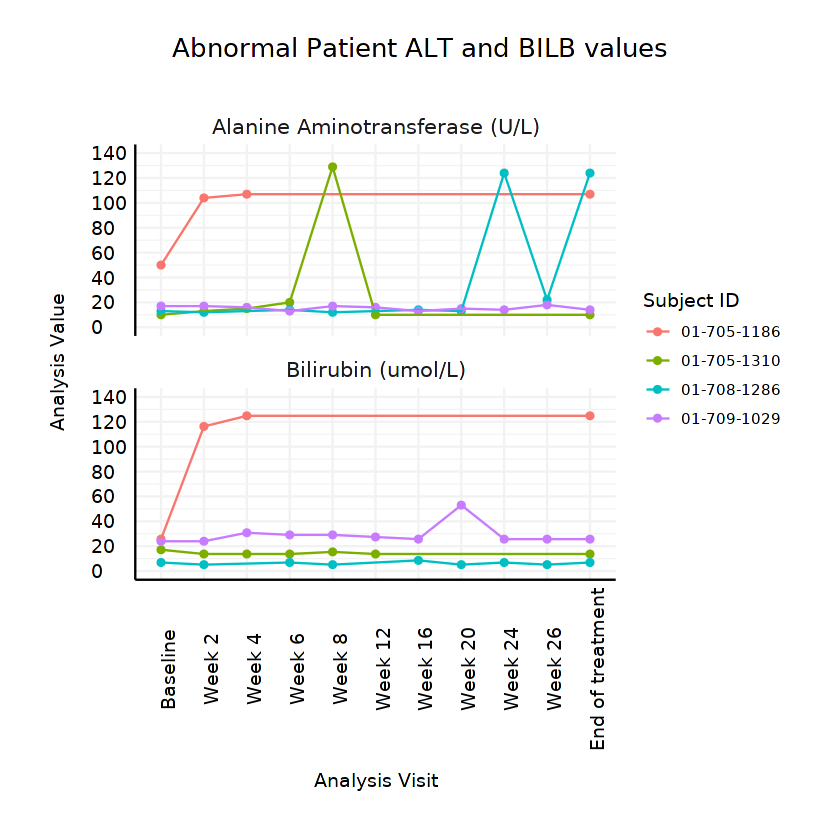

In [138]:
# pdf(file = "f_abnormalpatients_jupyter.pdf", height = 8, width = 14)

ggplot(data = abnormal_data) +
  # subgroup to split by
  facet_wrap(.~PARAM, ncol = 1, scales="free_y") +
  
  # add points
  geom_point(aes(x = AVISIT, y = AVAL, col = USUBJID)) +
  
  # connect with lines
  geom_line(aes(x = AVISIT, y = AVAL, col = USUBJID, group = USUBJID)) +
  
  # axis labels
  labs(x = "Analysis Visit",
       y = "Analysis Value",
       title = "Abnormal Patient ALT and BILB values") +
  
  #limits
  scale_y_continuous( limits = c(0, 20*round(ceiling(ymax/20))),
                      breaks = seq(0, 20*round(ceiling(ymax/20)), 20)) +
  
  # name legend
  scale_color_discrete(name = "Subject ID") +
  
  # theme
  theme( 
         strip.background = element_blank(),
         # legend.position = "top",
         legend.key=element_blank(),
         axis.line = element_line(colour = "black"),
         axis.ticks = element_blank(),
         strip.text = element_text(size = 8,
                                   margin = margin(b = 5)),
         panel.background = element_rect(fill = "white"),
         # panel.border = element_rect(colour = "black", fill=NA, size=1),
         panel.grid = element_line(colour = "grey95"),
         plot.title = element_text(size = 15,
                                   hjust = 0.5,
                                   vjust = 10),
         plot.margin = margin(50, 30, 30, 30),
         plot.title.position = 'plot',
         panel.spacing = unit(0.2, 'in'),
         strip.text.x = element_text(size = 12),
         axis.title.x = element_text(size = 11,
                                     margin = margin(t = 15),
                                     color = "black"),
         axis.title.y = element_text(size = 11,
                                     margin = margin(r = 15),
                                     color = "black"),
         plot.subtitle = element_text(size = 11,
                                      margin = margin(b = 15)),
         axis.text.x = element_text(size = 11,
                                    color = "black",
                                    angle = 90),
         axis.text.y = element_text(size = 11,
                                    color = "black",
                                    hjust = 0))

#dev.off() # Closes the plot and saves it as file

#
- <span style="color:red">01-705-1186</span>: consitently high ALT and BILI from Week 2
- <span style="color:limegreen">01-705-1310</span>: peak in ALT at Week 8
- <span style="color:turquoise">01-708-1286</span>: peak in ALT at Week 24 and End of Treatment
- <span style="color:orchid">01-709-1029</span>: peak in BILI at Week 20
